In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec 
from scipy import stats
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
import warnings
warnings.simplefilter(action='ignore')

from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import math
import sklearn.model_selection as ms
import sklearn.metrics as sklm
from pandas_profiling import ProfileReport

In [3]:
train = pd.read_csv('Housing Dreams/house_train_raw.csv')
test = pd.read_csv('Housing Dreams/houses_test_raw.csv')

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
# se guarda los indices de Test para posteriomente borrarlos
test_id = test['Id']
train.drop('Id', axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)

In [7]:
# se visualiza la cantidad de columnas y filas de ambos dataframes

print(f"El número de filas y columnas del train dataset son: {train.shape[0]} y {train.shape[1]}")
print(f"El número de filas y columnas del test dataset son: {test.shape[0]} y {test.shape[1]}")

El número de filas y columnas del train dataset son: 1460 y 80
El número de filas y columnas del test dataset son: 1459 y 79


Hay 1 columna menos en el conjunto de datos de prueba "test" porque necesitamos predecir el precio de las casas para el conjunto de datos de prueba

## Análisis de la columna Precio de venta

Se explora la funcion objetivo. En este caso en particular  se analizará **SalePrice**

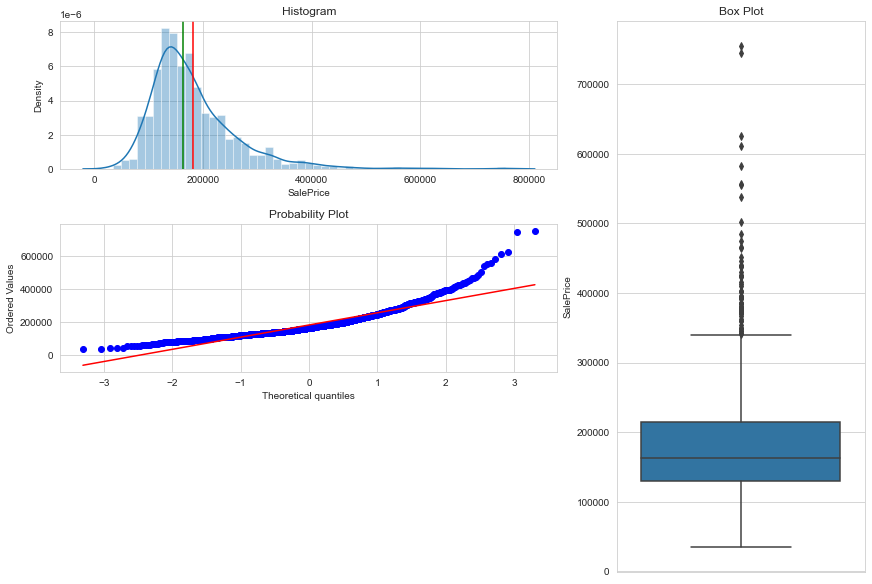

In [18]:
df= train

def three_chart_plot(df, feature):
    fig = plt.figure(constrained_layout = True, figsize = (12, 8))
    grid = gridspec.GridSpec(ncols = 3, nrows = 3, figure = fig)
    
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    
    sns.distplot(df.loc[:, feature], norm_hist = True, ax = ax1)
    plt.axvline(x = df[feature].mean(), c = 'red')
    plt.axvline(x = df[feature].median(), c = 'green')
    
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('QQ_plot')
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title.
    ax3.set_title('Box Plot')
    sns.boxplot(y=df.loc[:,feature], orient = 'v', ax = ax3 )
    
three_chart_plot(df, 'SalePrice')

**La línea roja en el histograma indica la media de SalePrice y la línea verde indica la mediana**

- A partir de los gráficos anteriores se puede observar que el precio de venta no posee una distribucion normal. Del diagrama de caja se observa que el conjunto de datos tiene una gran cantidad de outliers.
- En la gráfica de probabilidad, la línea roja representa aquellos puntos que se hubieran trazado para los puntos del eje y **si estos tuvieran una distribucion normal**. Los puntos azules representan el comportamiento real.


In [21]:
from scipy.stats import skew
print("La asimetría del SalesPrice es:", df['SalePrice'].skew())

La asimetría del SalesPrice es: 1.8828757597682129


La asimetría se refiere a la cantidad de asimetría en la característica dada o, en otras palabras, la cantidad de distorsiones de la distribución normal.
Se observa que el valor de la asimetría es bastante alto, esto significa que hay una gran cantidad de asimetría. La asimetria presente es positiva.

# Valores Nulos

Hay una biblioteca increíble llamada missingno que nos ayuda a visualizar la cantidad de valores nulos presentes en cada característica

<AxesSubplot:>

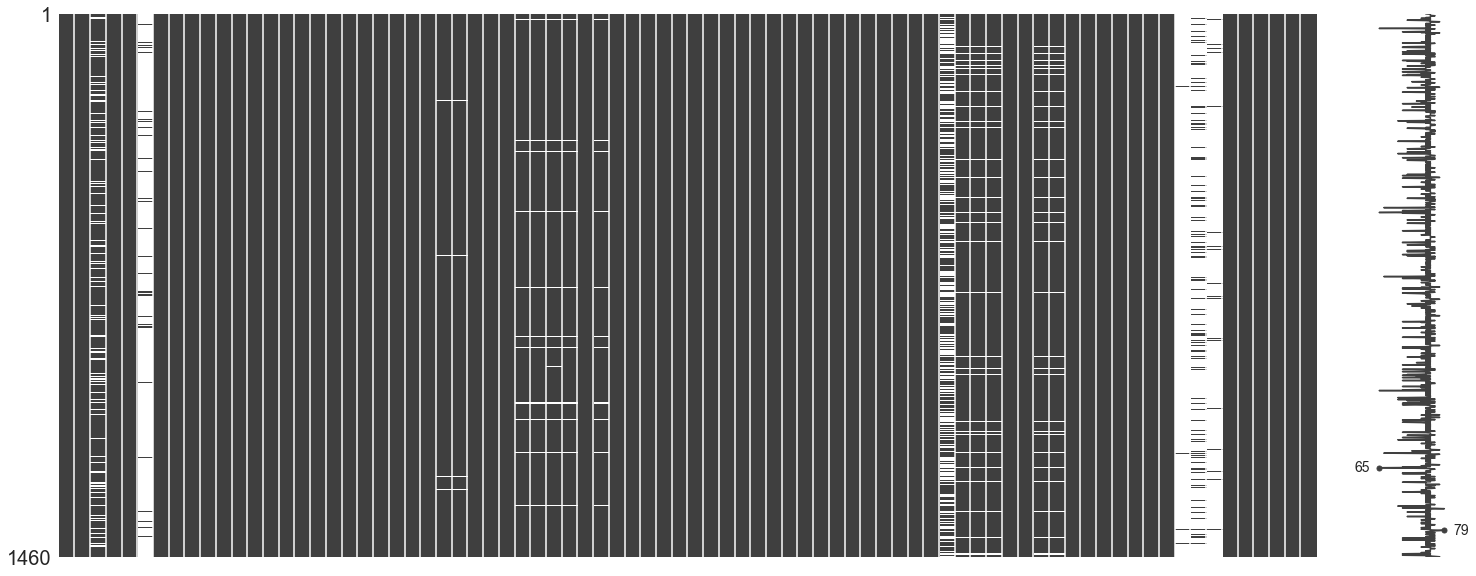

In [22]:
import missingno as msno
%matplotlib inline
msno.matrix(train)

Se observa gran cantidad de valores Null

<AxesSubplot:>

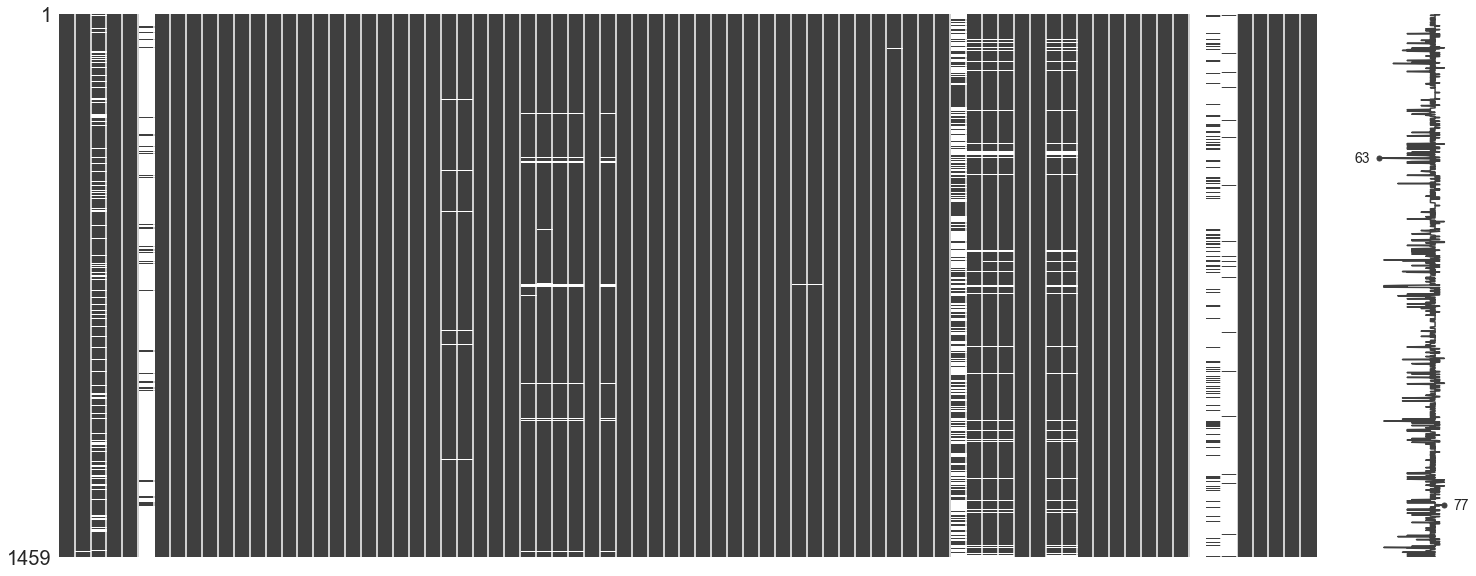

In [23]:
msno.matrix(test)

In [25]:
def null_table(data):
    """
    Funcion q devuelve el numero y porcentaje de valores nulos de un dataset
    """
    indices = data.isnull().sum().index
    values = data.isnull().sum().values
    percentages = []
    for i in indices:
        percentages.append((data[i].isnull().sum() / data[i].shape[0]) * 100)
    d = {'Columns' : indices, 'Count of Null Values' : values, 'Approximate Percentage of Null Values' : percentages}
    # data = dict(zip(indices, percentages))
    null_frame = pd.DataFrame(data = d)
    return null_frame

In [26]:
null_frame_train = null_table(df)
null_frame_train.sort_values(by = 'Approximate Percentage of Null Values').tail(10)

,Columns,Count of Null Values,Approximate Percentage of Null Values
62,GarageQual,81,5.547945
59,GarageFinish,81,5.547945
63,GarageCond,81,5.547945
57,GarageType,81,5.547945
2,LotFrontage,259,17.739726
56,FireplaceQu,690,47.260274
72,Fence,1179,80.753425
5,Alley,1369,93.767123
73,MiscFeature,1406,96.301370
71,PoolQC,1453,99.520548


In [27]:
null_frame_test = null_table(test)
null_frame_test.sort_values(by = 'Approximate Percentage of Null Values').tail(10)

,Columns,Count of Null Values,Approximate Percentage of Null Values
62,GarageQual,78,5.346127
58,GarageYrBlt,78,5.346127
59,GarageFinish,78,5.346127
63,GarageCond,78,5.346127
2,LotFrontage,227,15.558602
56,FireplaceQu,730,50.034270
72,Fence,1169,80.123372
5,Alley,1352,92.666210
73,MiscFeature,1408,96.504455
71,PoolQC,1456,99.794380


Debemos observar aquí que NA tiene un significado diferente, no se puede eliminar ni imputar las filas q contienen vales NA. Por ejemplo, si uno de los valores de Alley es NA, significa que la casa no tiene Alley o si el valor de GarageType es NA, significa que esa casa en particular no tiene garaje.Por eso hay que tener en cuenta estos valores ya que pueden afectar a los precios finales de la vivienda.


In [31]:
# Se analiza los valores nulos al combinar ambos datasets

na = train.shape[0]
nb = test.shape[0]
y_train = train['SalePrice'].to_frame()
# Combinar train y test datasets
total = pd.concat((train, test), sort = False).reset_index(drop = True)
#Se elimina las columnas "SalePrice" e Id 
total.drop(['SalePrice'], axis = 1, inplace = True)
print(f"La medida del dataset Total es: {total.shape}")

La medida del dataset Total es: (2919, 79)


In [33]:
def msv_1(data, thresh = 20, color = 'black', edgecolor = 'black', height = 3, width = 15):
    
    plt.figure(figsize = (width, height))
    percentage = (data.isnull().mean()) * 100
    percentage.sort_values(ascending = False).plot.bar(color = color, edgecolor = edgecolor)
    plt.axhline(y = thresh, color = 'r', linestyle = '-')
    
    plt.title(' Porcentaje de Valores olvidados por columna', fontsize=20, weight='bold' )
    
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+12.5, f'Columnas con mas del {thresh}% Valores olvidados', fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, f'Columnas con menos del {thresh}% Valores olvidados', fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columnas', size=15, weight='bold')
    plt.ylabel('Porcentaje de Valores olvidados')
    plt.yticks(weight ='bold')
    
    return plt.show()


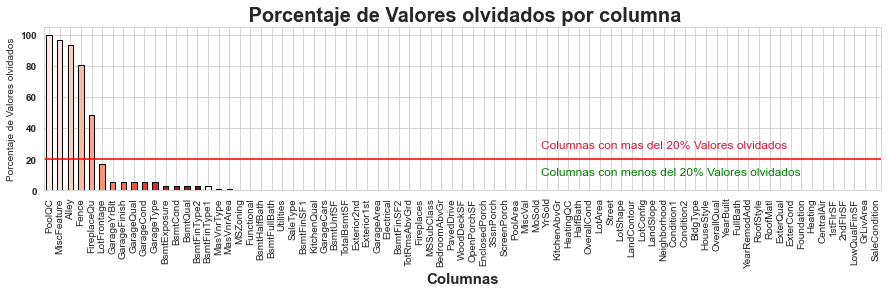

In [34]:
msv_1(total, 20, color=sns.color_palette('Reds',15))

# Variables Numericas  y Categóricas

Se procede a explorar las variables numéricas

In [35]:
category_var = df.select_dtypes(include = 'object')
num_var = df.select_dtypes(exclude = 'object')

print("Numero de variables categóricas: ", category_var.shape[1])
print("Número de variables numéricas: ", num_var.shape[1])

Numero de variables categóricas:  43
Número de variables numéricas:  37


Es preciso observar la correlacion de las variables numéricas con SalePrice

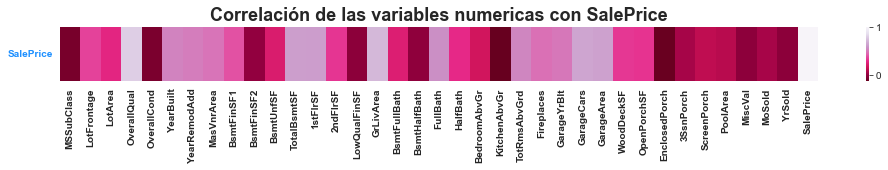

In [37]:
num = df.select_dtypes(exclude = 'object')
corr_num = num.corr()

f, ax = plt.subplots(figsize = (17, 1))

sns.heatmap(corr_num.sort_values(by = ['SalePrice'], ascending = False).head(1), cmap='PuRd_r')

plt.title('Correlación de las variables numericas con SalePrice', weight = 'bold', fontsize = 18)
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='dodgerblue', rotation=0)

plt.show()

In [38]:
correlation = df.corr()['SalePrice'].sort_values(ascending = False).to_frame().head(10)

cmap = sns.light_palette("cyan", as_cmap = True)

s = correlation.style.background_gradient(cmap = cmap)

s

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
